### Overview

In this section, we will work with MODIS Vegetation Indices Version 6.1 data which are generated every 16 days at 250 meter (m) spatial resolution. This dataset provides Normalised Differnece Vegetation Index (NDVI) and Enhanced Vegetation Index (EVI) processed from the MODIS data. The source data was downloaded and processed via [AρρEEARS](https://appeears.earthdatacloud.nasa.gov/) which allows for pre-processing of the data into user-specified AOIs.

Here we will working with GeoTIFF files in EPSG:4326 projection and  clipped to the state boundary of Karnataka, India. We will learn how to load all the files into a single XArray Dataset, apply a cloud-mask and extract a time-series of NDVI and EVI values.

### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas
    !pip install rioxarray

In [2]:
import datetime
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import zipfile

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


filename = 'modis_vegetation_indices_2020.zip'
url = 'https://storage.googleapis.com/spatialthoughts-public-data/' + filename

download(url)

Downloaded data/modis_vegetation_indices_2020.zip


### Data Pre-Processing

First we unzip and extract the images to a folder.

In [5]:
zipfile_path = os.path.join(data_folder, filename)
with zipfile.ZipFile(zipfile_path) as zf:
  zf.extractall(data_folder)

The timestamp for the image is part of the filename. We write a function to parse the filename and extract the timestamps.

In [6]:
def path_to_datetimeindex(filepath):
  filename = os.path.basename(filepath)
  pattern = r'doy(\d+)'
  match = re.search(pattern, filepath)
  if match:
      doy_value = match.group(1)
      timestamp = datetime.datetime.strptime(doy_value, '%Y%j')
      return timestamp
  else:
    print('Could not extract DOY from filename', filename)


timestamps = []
filepaths = []

files = os.path.join(data_folder, 'modis_vegetation_indices_2020', '*.tif')
for filepath in glob.glob(files):
  timestamp = path_to_datetimeindex(filepath)
  filepaths.append(filepath)
  timestamps.append(timestamp)

unique_timestamps = sorted(set(timestamps))

Iterate through each file and read it using XArray. There are 3 files for each time-step. One file each for `NDV`, `EVI` and `DetailedQA` information. We extract the first 2-bits of information from the `DetailedQA` band into a new band named `SummaryQA`. These 4 bands are combined into a single array for each time-step and then combine all the arrays into a single array with a `time` dimension.

In [7]:
scenes = []

for timestamp in unique_timestamps:
  ndvi_filepattern = r'NDVI_doy{}'.format(timestamp.strftime('%Y%j'))
  evi_filepattern = r'EVI_doy{}'.format(timestamp.strftime('%Y%j'))
  qa_filepattern = r'VI_Quality_doy{}'.format(timestamp.strftime('%Y%j'))
  ndvi_filepath = [filepath for filepath in filepaths if re.search(ndvi_filepattern, filepath)][0]
  evi_filepath = [filepath for filepath in filepaths if re.search(evi_filepattern, filepath)][0]
  qa_filepath = [filepath for filepath in filepaths if re.search(qa_filepattern, filepath)][0]

  ndvi_band = rxr.open_rasterio(ndvi_filepath, chunks={'x':512, 'y':512})
  ndvi_band.name = 'NDVI'
  evi_band = rxr.open_rasterio(evi_filepath, chunks={'x':512, 'y':512})
  evi_band.name = 'EVI'
  qa_band = rxr.open_rasterio(qa_filepath, chunks={'x':512, 'y':512})
  qa_band.name = 'DetailedQA'

  # First 2 bits are MODLAND QA Bits with summary information
  # Extract the value of the 2-bits using bitwise AND operation
  summary_qa = qa_band & 0b11
  qa_band.name = 'SummaryQA'

  # Pixel values need to be scaled with the scale_factor
  scale_factor = 0.0001
  scaled_bands = [ndvi_band * scale_factor, evi_band * scale_factor, qa_band, summary_qa]
  scene = xr.concat(scaled_bands, dim='band')
  scenes.append(scene)

In [ ]:
time_var = xr.Variable('time', list(unique_timestamps))

time_series_scenes = xr.concat(scenes, dim=time_var)
time_series_scenes

In [ ]:
time_series_scenes = time_series_scenes.assign_coords(band=['NDVI', 'EVI', 'DetailedQA', 'SummaryQA'])
time_series_scenes

### Cloud Masking

As described in the [MODIS VI User Guide](https://vip.arizona.edu/documents/MODIS/MODIS_VI_UsersGuide_June_2015_C6.pdf) MOD13Q1/A1 QA band contains pixel values representing overall pixel quality.

| Value | Summary QA    | Description |
| ----- | --------------|-------------|
| -1    | Fill/No Data  | Not Processed |
| 0     | Good Data     | Use with confidence |
| 1     | Marginal data | Useful, but look at other QA information |
| 2     | Snow/Ice      |Target covered with snow/ice |
| 3    | Cloudy        |Target not visible, covered with cloud |

We select all pixels with values 0 or 1 and mask all pixels with snow or cloud.


In [ ]:
summary_qa = time_series_scenes.sel(band='SummaryQA')
time_series_scenes_masked = time_series_scenes.sel(band=['NDVI', 'EVI']).where(summary_qa <= 1)
time_series_scenes_masked

## Extracting the time-series

We extract the time-series at a specific X,Y coordinate.

In [15]:
time_series = time_series_scenes.sel(band=['NDVI', 'EVI']).interp(y=13.16, x=77.35)

This time-series has cloudy pixels which show up as anomalous NDVI and EVI values.

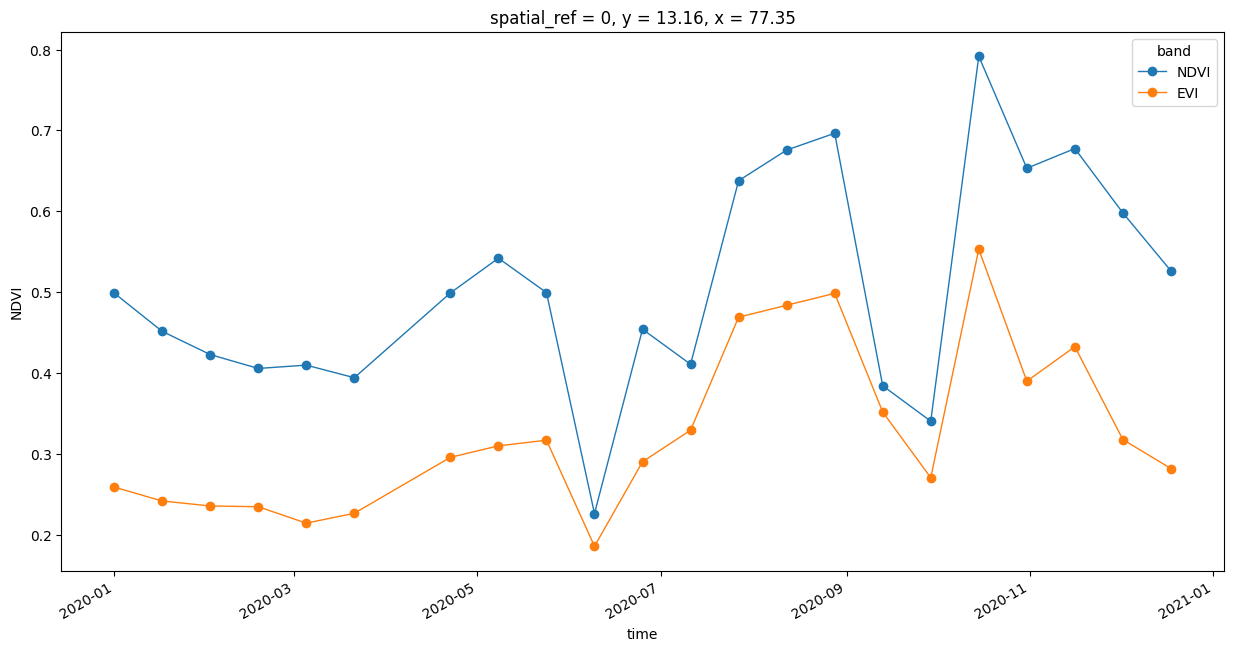

In [16]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(15, 7)
time_series.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

Let's plot the cloud-masked time-series.

In [17]:
time_series_masked = time_series_scenes_masked.sel(band=['NDVI', 'EVI']).interp(y=13.16, x=77.35)

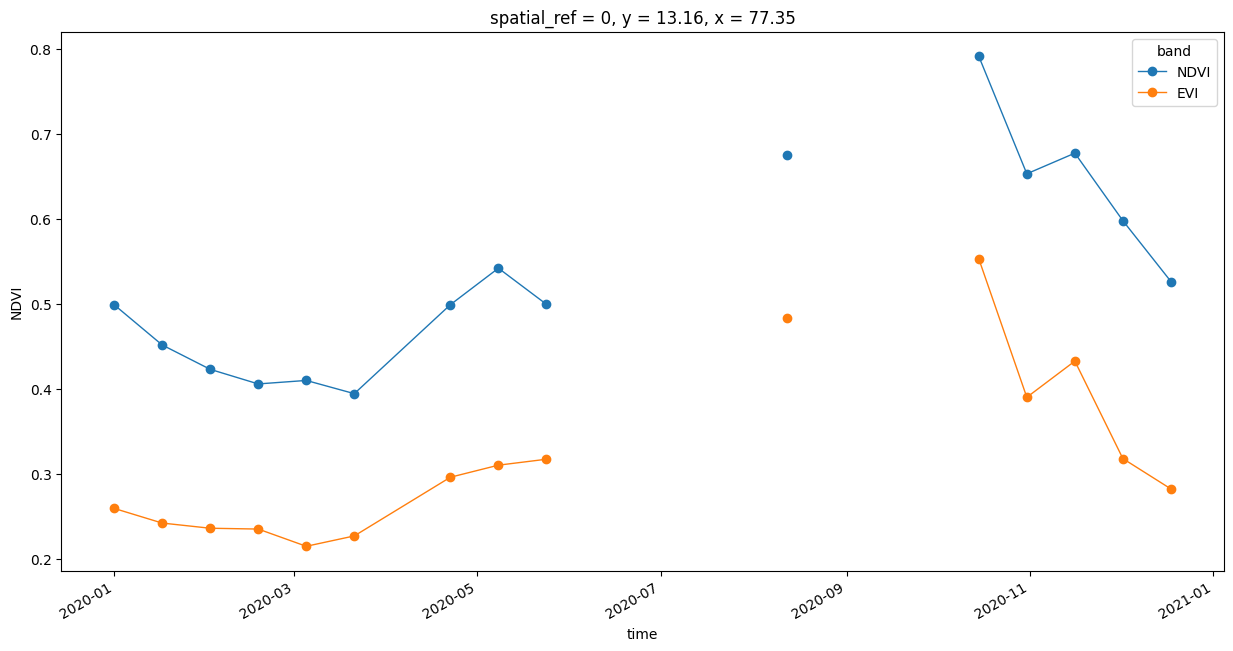

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_masked.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

This looks much better, but we have gaps in the time-series due to masked cloudy-pixels. Replace them with linearly interpolated values.

In [19]:
time_series_masked_interpolated = time_series_masked.chunk(dict(time=-1)).interpolate_na('time')

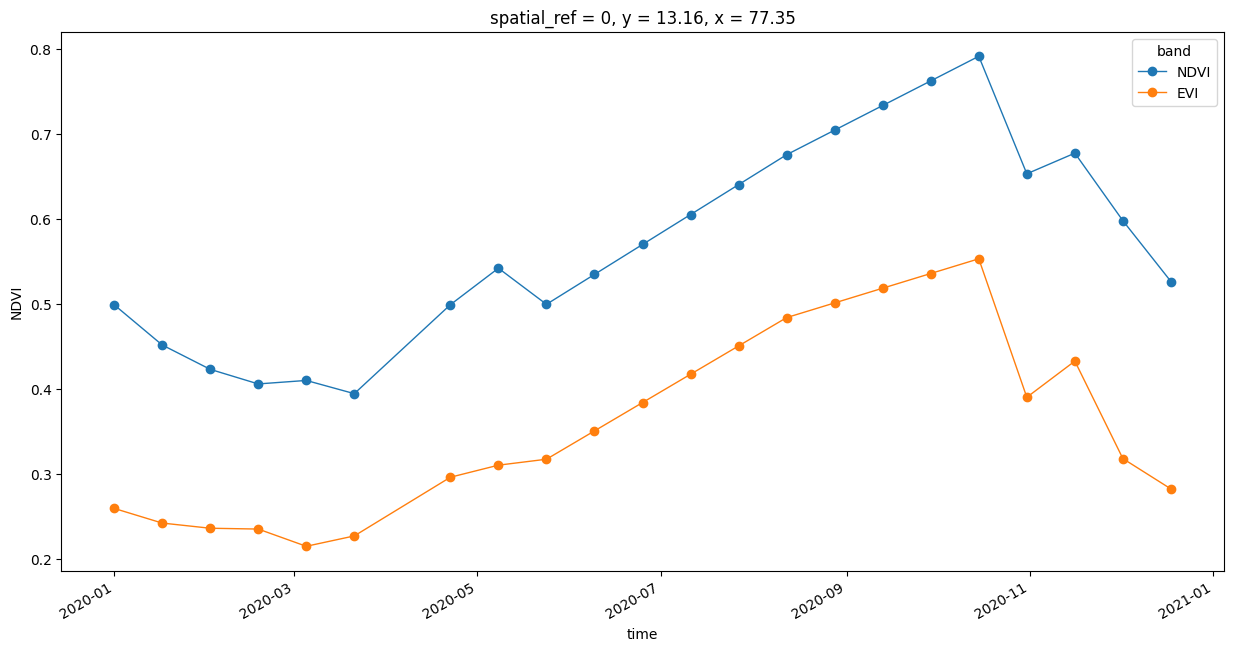

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_masked_interpolated.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

We can set the series colors to our choice of colors using Matplotlib Cycler.

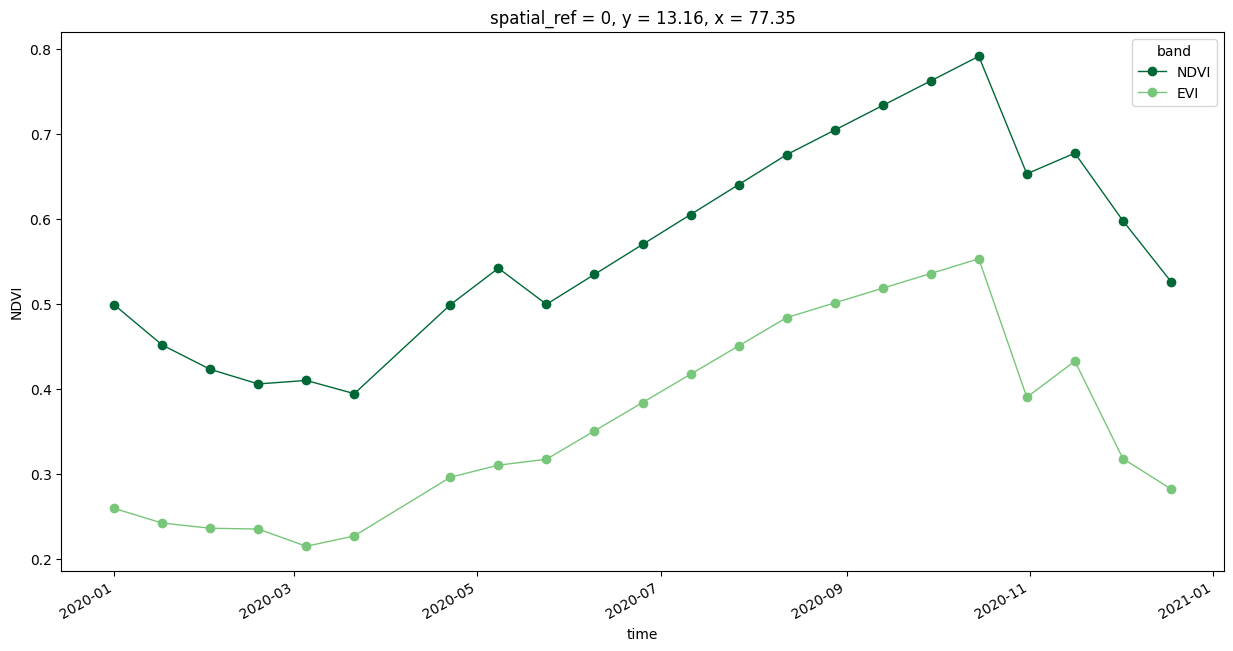

In [21]:
from cycler import cycler
import matplotlib as mpl

colorlist = ['#006837', '#78c679']
custom_cycler = cycler(color=colorlist)

fig, ax = plt.subplots(1, 1)
ax.set_prop_cycle(custom_cycler)

fig.set_size_inches(15, 7)
time_series_masked_interpolated.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

In [ ]:
df = time_series_masked.to_pandas()
df = df.fillna(-9999)
df

In [23]:
output_filename = 'original_time_series.csv'
output_filepath = os.path.join(output_folder, output_filename)
df.reset_index().to_csv(output_filepath, index=False)

### Exercise

Create another CSV file `interpolated_time_series.csv` containing the linearly interpolated NDVI and EVI values.